# Importing the environment requirements


## Mount drive

In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install pip packages


In [ ]:
import yaml
import subprocess

root_path = "/content/drive/MyDrive/SemEval-2026_Task4-Narrative-Similarity"

with open(f"{root_path}/environment.yaml") as f:
    env = yaml.safe_load(f)

# Collect pip packages
pip_packages = []
for dep in env.get("dependencies", []):
    if isinstance(dep, dict) and "pip" in dep:
        pip_packages.extend(dep["pip"])

# Install all pip packages at once
if pip_packages:
    subprocess.run(["pip", "install", *pip_packages])

In [ ]:
!pip install detectors
!pip install jsonlines
!pip install evaluate
!pip install rouge_score

  Using cached detectors-0.1.11-py3-none-any.whl.metadata (9.3 kB)
  Using cached optuna-4.6.0-py3-none-any.whl.metadata (17 kB)
  Using cached colorlog-6.10.1-py3-none-any.whl.metadata (11 kB)
  Using cached ogb-1.3.6-py3-none-any.whl.metadata (6.2 kB)
  Using cached outdated-0.2.2-py2.py3-none-any.whl.metadata (4.7 kB)
  Using cached littleutils-0.2.4-py3-none-any.whl.metadata (679 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.8/616.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 

### Verify the installation


In [ ]:
!pip show detectors

Name: detectors
Version: 0.1.11
Summary: Detectors: a python package to benchmark generalized out-of-distribution detection methods.
Home-page: https://github.com/edadaltocg/detectors
Author: Eduardo Dadalto
Author-email: edadaltocg@gmail.com
License: APACHE 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: accelerate, faiss-cpu, matplotlib, numpy, optuna, pandas, Pillow, psutil, scikit-image, scikit-learn, scipy, timm, torch, torchvision, tqdm, wilds
Required-by: 


### Import

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import timm
import detectors
import yaml
import torch
import sys
import os
import rouge_score
import json
import pandas as pd
import difflib
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate
import re

# Data Mining on SemEval_Task4 data

In [ ]:
root_path = "/content/drive/MyDrive/SemEval-2026_Task4-Narrative-Similarity/data"
clasification_data_path = os.path.join(root_path, "synthetic_data_for_classification.jsonl")

data = []
with open(clasification_data_path, 'r') as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data).dropna(subset=['anchor_text', 'text_a', 'text_b'])


# compute (ROGUE) structural similarity

In [ ]:
rouge_metric = evaluate.load("rouge")

def get_rogue_str_sim(t1, t2):
    return rouge_metric.compute(predictions=[t1], references=[t2])['rouge1']

df['similarity_anchor_a'] = df.apply(lambda x: get_rogue_str_sim(x['anchor_text'], x['text_a']), axis=1)
df['similarity_anchor_b'] = df.apply(lambda x: get_rogue_str_sim(x['anchor_text'], x['text_b']), axis=1)


 ## Generate Scatter Plot Method

In [ ]:
def generate_plot(x_label, y_label, hue_label, structural, title_text, xl, yl):
  sns.set_theme(style="whitegrid")
  plt.figure(figsize=(8,6))

  # Scatter plot
  sns.scatterplot(
      data=df,
      x=x_label,
      y=y_label,
      hue=hue_label,
      palette='coolwarm',
      alpha=0.5
  )

  if structural is True:
    label='y=x (Structural Boundary)'
  else:
    label='y=x (Thematic Boundary)'
  plt.plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=2, label=label)

  plt.title(title_text, fontsize=15)
  plt.xlabel(xl, fontsize=12)
  plt.ylabel(yl, fontsize=12)

  plt.legend(title='Ground Truth: Is A Closer?')
  plt.grid(True, linestyle=':', alpha=0.6)
  plt.tight_layout()
  plt.show()

## Generate (ROGUE) Scatter Plot

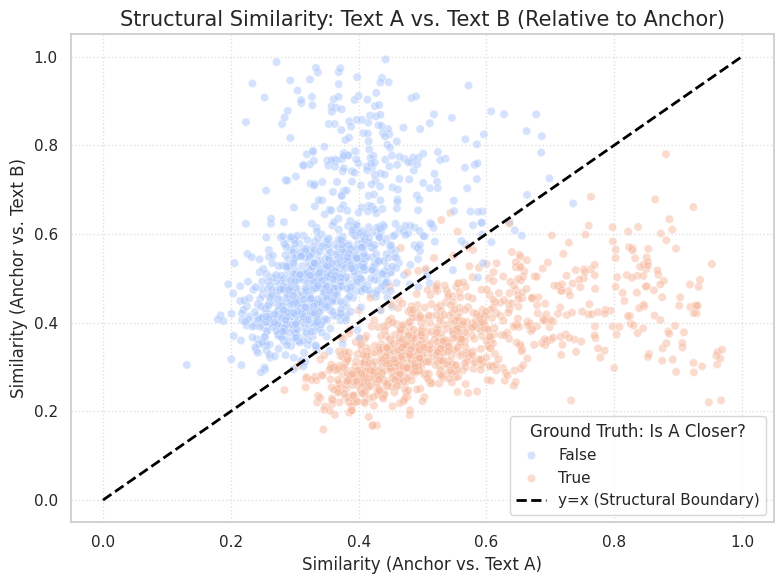

In [ ]:
generate_plot('similarity_anchor_a',
              'similarity_anchor_b',
              'text_a_is_closer',
              structural = True,
              title_text = 'Structural Similarity: Text A vs. Text B (Relative to Anchor)',
              xl = 'Similarity (Anchor vs. Text A)',
              yl = 'Similarity (Anchor vs. Text B)')

In [ ]:
print(f"The number of A stories closer to anchor: {len(df[df['text_a_is_closer'] == True])}")
print(f"The number of B stories closer to anchor: {len(df[df['text_a_is_closer'] == False])}")

The number of A stories closer to anchor: 940
The number of B stories closer to anchor: 957


# Compute Thematic similarity

In [ ]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 5.1.2
    Uninstalling sentence-transformers-5.1.2:
      Successfully uninstalled sentence-transformers-5.1.2


## Text_a vs. Text_b thematic similarity (Relative to Anchor)

In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L6-v2')

def get_thematic_similarity(t1, t2):
  emb_anchor = model.encode(t1)
  emb_a = model.encode(t2)
  score = util.cos_sim(emb_anchor, emb_a).item()
  return score

df['similarity_thematic_anchor_a'] = df.apply(lambda x: get_thematic_similarity(x['anchor_text'], x['text_a']), axis=1)
df['similarity_thematic_anchor_b'] = df.apply(lambda x: get_thematic_similarity(x['anchor_text'], x['text_b']), axis=1)

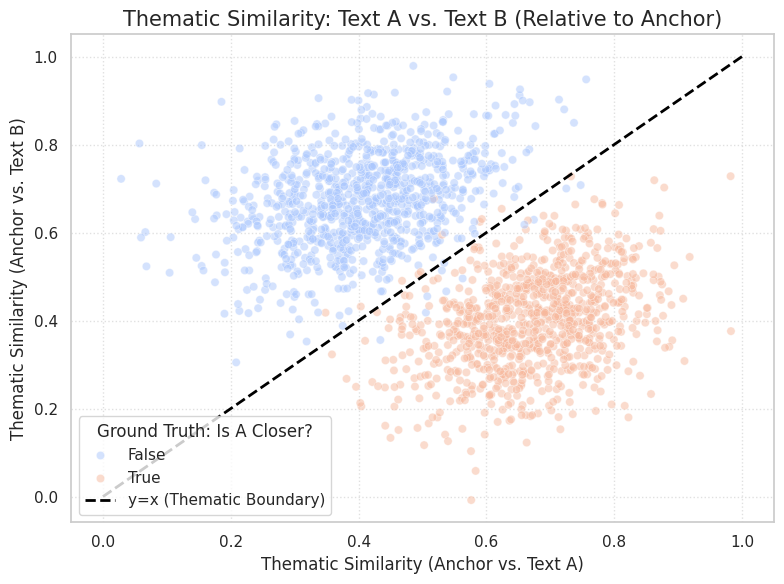

In [ ]:
generate_plot('similarity_thematic_anchor_a',
              'similarity_thematic_anchor_b',
              'text_a_is_closer',
              structural = False,
              title_text = 'Thematic Similarity: Text A vs. Text B (Relative to Anchor)',
              xl = 'Thematic Similarity (Anchor vs. Text A)',
              yl = 'Thematic Similarity (Anchor vs. Text B)')

## Text_a vs. Text_b thematic similarity (Relative to Eachother)



In [ ]:
df['thematic_similarity_a_b'] = df.apply(lambda x: get_thematic_similarity(x['text_a'], x['text_b']), axis=1)

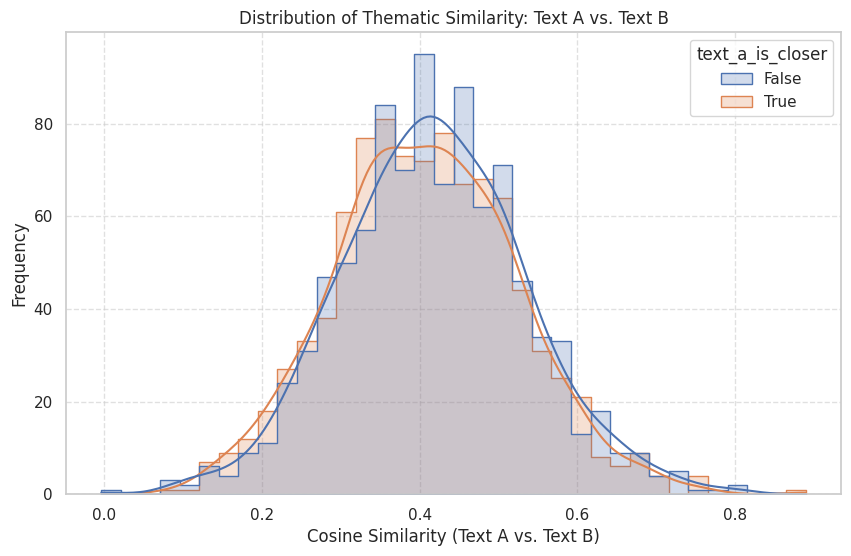

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='thematic_similarity_a_b', hue='text_a_is_closer', kde=True, element="step")

plt.title('Distribution of Thematic Similarity: Text A vs. Text B')
plt.xlabel('Cosine Similarity (Text A vs. Text B)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Text length distribution

Anchor Text: Average length of aprox. 950 characters.

Candidate Texts (A & B): Slightly longer on average, at aprox. 1,030 characters.

The lengths are consistent across both text_a and text_b, indicating a controlled generation process to prevent models from using length alone as a simple heuristic for similarity.

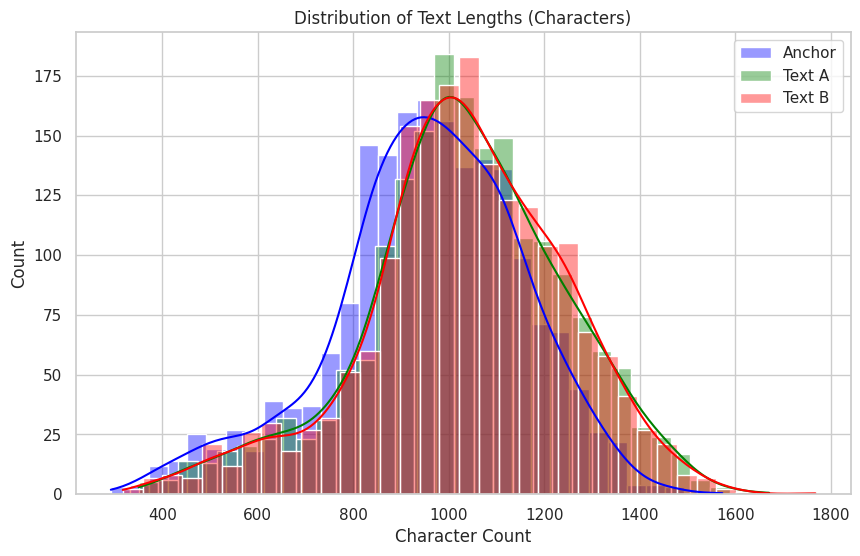

In [ ]:
df['anchor_len'] = df['anchor_text'].apply(len)
df['text_a_len'] = df['text_a'].apply(len)
df['text_b_len'] = df['text_b'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df['anchor_len'], color='blue', label='Anchor', kde=True, alpha=0.4)
sns.histplot(df['text_a_len'], color='green', label='Text A', kde=True, alpha=0.4)
sns.histplot(df['text_b_len'], color='red', label='Text B', kde=True, alpha=0.4)
plt.title('Distribution of Text Lengths (Characters)')
plt.xlabel('Character Count')
plt.legend()
plt.show()
plt.close()

## Jaccard Word Overlap

Here the negative OD (Overlap Differnece) and the positive OD indicate that the amount of text A and B consists of similar vocabulary with the Anchor text.

The OD = 0 suggests that a small portion of vocabulary of Text A and Text B are very similar to each other (Relative to the Anchor text)


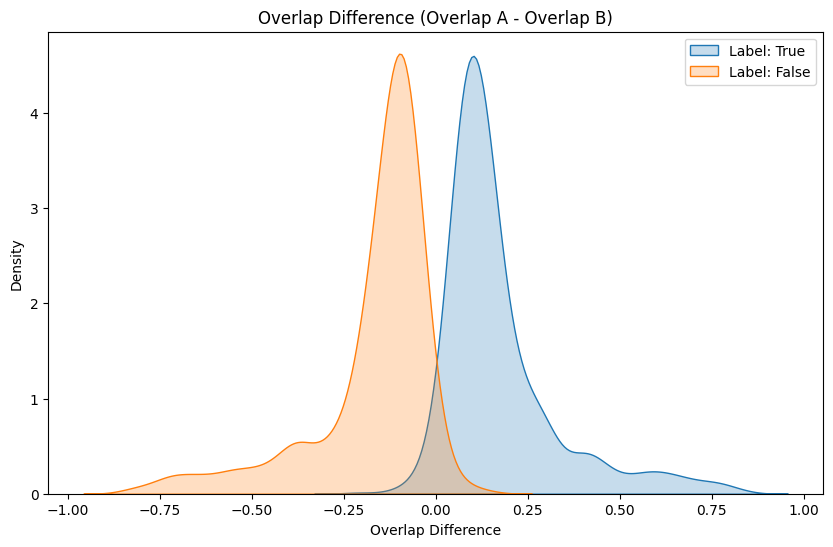

In [ ]:
def get_word_overlap(text1, text2):
    set1 = set(re.findall(r'\w+', text1.lower()))
    set2 = set(re.findall(r'\w+', text2.lower()))
    if not set1 or not set2: return 0
    return len(set1.intersection(set2)) / len(set1.union(set2))

df['overlap_a'] = df.apply(lambda row: get_word_overlap(row['anchor_text'], row['text_a']), axis=1)
df['overlap_b'] = df.apply(lambda row: get_word_overlap(row['anchor_text'], row['text_b']), axis=1)
df['overlap_diff'] = df['overlap_a'] - df['overlap_b']

plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['text_a_is_closer'] == True]['overlap_diff'], label='Label: True', fill=True)
sns.kdeplot(df[df['text_a_is_closer'] == False]['overlap_diff'], label='Label: False', fill=True)
plt.title('Overlap Difference (Overlap A - Overlap B)')
plt.xlabel('Overlap Difference')
plt.legend()
plt.show()
plt.close()

# Preprocessing the data

In [ ]:
def preprocessing(config):
    if config['dataset']['name'] == 'MNIST':
        train_transformer = transforms.Compose([
            transforms.RandomAffine(degrees=2, translate=[0.1, 0.1]),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.1307,), std=(0.3081,))
        ])
        test_transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.1307,), std=(0.3081,))
        ])
        train_dataset = datasets.MNIST(root=f'{config["dataset"]["data_dir"]}/train', train=True, transform=train_transformer, download=True)
        test_dataset = datasets.MNIST(root=f'{config["dataset"]["data_dir"]}/test', train=False, transform=test_transformer, download=True)
        train_loader = DataLoader(train_dataset, batch_size=config['dataset']['batch_size'], shuffle=True, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=config['dataset']['batch_size'], shuffle=False, pin_memory=True)
        return train_loader, test_loader

    elif config['dataset']['name'] == 'CIFAR10':
        mean = list(map(float, config["dataset"]["mean"]))
        std = list(map(float, config["dataset"]["std"]))

        train_transformer = transforms.Compose([
            # transforms.ToPILImage(),
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        test_transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        train_dataset = datasets.CIFAR10(root=f'{config["dataset"]["data_dir"]}/train', train=True, transform=train_transformer, download=True)
        test_dataset = datasets.CIFAR10(root=f'{config["dataset"]["data_dir"]}/test', train=False, transform=test_transformer, download=True)
        train_loader = DataLoader(train_dataset, batch_size=config['dataset']['batch_size'], shuffle=True, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=config['dataset']['batch_size'], shuffle=False, pin_memory=True)
        return train_loader, test_loader

    elif config['dataset']['name'] == 'CIFAR100':
        mean = list(map(float, config["dataset"]["mean"]))
        std = list(map(float, config["dataset"]["std"]))

        train_transformer = transforms.Compose([
            # transforms.ToPILImage(),
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        test_transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        train_dataset = datasets.CIFAR100(root=f'{config["dataset"]["data_dir"]}/train', train=True, transform=train_transformer, download=True)
        test_dataset = datasets.CIFAR100(root=f'{config["dataset"]["data_dir"]}/test', train=False, transform=test_transformer, download=True)
        train_loader = DataLoader(train_dataset, batch_size=config['dataset']['batch_size'], shuffle=True, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=config['dataset']['batch_size'], shuffle=False, pin_memory=True)
        return train_loader, test_loader

    elif config['dataset']['name'] == 'OxfordIIITPet':
        mean = list(map(float, config["dataset"]["mean"]))
        std = list(map(float, config["dataset"]["std"]))

        train_transformer = transforms.Compose([
            # transforms.ToPILImage(),
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        test_transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

        train_dataset = datasets.OxfordIIITPet(root=f'{config["dataset"]["data_dir"]}/train', train=True, transform=train_transformer, download=True)
        test_dataset = datasets.OxfordIIITPet(root=f'{config["dataset"]["data_dir"]}/test', train=False, transform=test_transformer, download=True)
        train_loader = DataLoader(train_dataset, batch_size=config['dataset']['batch_size'], shuffle=True, pin_memory=True)
        test_loader = DataLoader(test_dataset, batch_size=config['dataset']['batch_size'], shuffle=False, pin_memory=True)
        return train_loader, test_loader
    else:
        print('The dataset name you have entered is not supported!')
        sys.exit()

# Get the Loss Function

In [ ]:
def get_loss_function(name):
    name = name.lower()
    if name == 'crossentropyloss':
        print('CrossEntropyLoss Loss Function loaded!')
        return torch.nn.CrossEntropyLoss()
    elif name == 'mseloss':
        print('MSELoss Loss Function loaded!')
        return torch.nn.MSELoss()
    else:
        print('The loss function name you have entered is not supported!')
        sys.exit()

# Get Learning Rate Scheduler

In [ ]:
def get_lr_scheduler(configs, optimizer):
    name = configs["training"]["scheduler"].lower()
    if name == 'steplr':
        print('StepLR Learning Rate Scheduler loaded!')
        return torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=configs["training"]["step_size"],
                                               gamma=configs["training"]["gamma"])
    elif name == 'reducelronplateau':
        print('ReduceLROnPlateau Learning Rate Scheduler loaded!')
        return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                          mode=configs["training"]["mode"],
                                                          factor=configs["training"]["factor"],
                                                          patience=configs["training"]["patience"],
                                                          threshold=configs["training"]["threshold"])
    else:
        print('The Learning Rate Scheduler name you have entered is not supported!')
        sys.exit()

# Get the model

In [ ]:
def get_model(name, config):
    name = name.lower()
    if name == 'resnet50':
        # model = timm.create_model("hf_hub:anonauthors/cifar100-timm-resnet50", pretrained=config['model']['pretrained'])  # https://huggingface.co/anonauthors/cifar100-timm-resnet50
        model = timm.create_model("resnet50_cifar100", pretrained=True)     # https://huggingface.co/edadaltocg/resnet50_cifar100
        print('Model resnet50_cifar100 loaded!')
        return model
    elif name == 'resnet18':
        model = timm.create_model("resnet18_cifar100", pretrained=config['model']['pretrained'])    # https://huggingface.co/edadaltocg/resnet18_cifar100
        print('Model resnet18_cifar100 loaded!')
        return model
    elif name == 'resnest14d':
        model = timm.create_model("hf_hub:timm/resnest14d.gluon_in1k", pretrained=config['model']['pretrained'])
        print('Model resnest14d.gluon_in1k loaded!')
        return model
    elif name == 'resnest26d':
        model = timm.create_model("hf_hub:timm/resnest26d.gluon_in1k", pretrained=config['model']['pretrained'])
        print('Model resnest26d.gluon_in1k loaded!')
        return model
    elif name == 'MLP':
        pass
    else:
        print('The network name you have entered is not supported!')
        sys.exit()

# Get the optimizer

In [ ]:
def get_optimizer(configs, params):
    name = configs["training"]["optimizer"].lower()
    if name == 'sgd':
        print('SGD Optimizer loaded!')
        return torch.optim.SGD(params, lr=configs["training"]["learning_rate"], momentum=configs["training"]["momentum"], weight_decay=float(configs["training"]["weight_decay"]))
    elif name == 'adam':
        print('Adam Optimizer loaded!')
        return torch.optim.Adam(params, lr=configs["training"]["learning_rate"])
    elif name == 'adamw':
        print('AdamW Optimizer loaded!')
        return torch.optim.AdamW(params, lr=configs["training"]["learning_rate"], weight_decay=float(configs["training"]["weight_decay"]))
    elif name == 'muon':
        print('Muon Optimizer loaded!')
        return torch.optim.Muon(params, lr=configs["training"]["learning_rate"], weight_decay=float(configs["training"]["weight_decay"]))
    # elif name == 'sam':
    #     print('Optimizer loaded!')
    #     # base_optim = torch.optim.SGD(params, lr=configs["training"]["learning_rate"], momentum=configs["training"]["momentum"], weight_decay=float(configs["training"]["weight_decay"]))
    #     base_optim = torch.optim.SGD
    #     return SAM(params, base_optim, lr=configs["training"]["learning_rate"], momentum=float(configs["training"]["momentum"]))
    else:
        print('The optimizer name you have entered is not supported!')
        sys.exit()

# Get YAML Configuration

In [ ]:
def load_config(config_path):
    with open(config_path) as f:
        config = yaml.safe_load(f)
    return config

# Get Mixed Precision

In [ ]:
def get_mixed_precision():
    return torch.amp.GradScaler()

# Training the model

In [ ]:
import os
from tqdm import tqdm
import torch
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import pprint
import wandb

wandb.login()
scaler = get_mixed_precision()


def train_per_epoch(epoch):
    global model, optimizer, loss_function, scheduler, writer, train_loader

    model.train()
    train_loss = 0.0

    for batch_index, (train_images, train_labels) in enumerate(
            tqdm(train_loader, desc=f"Epoch {epoch}")
    ):
        train_images, train_labels = train_images.to(device), train_labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(train_images)
            loss = loss_function(outputs, train_labels)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        n_iter = (epoch - 1) * len(train_loader) + batch_index + 1
        writer.add_scalar("Train/Loss", loss.item(), n_iter)

        # W&B
        wandb.log({"train_loss": loss.item()})

        train_loss += loss.item()

    scheduler.step()

    return train_loss / len(train_loader)


@torch.no_grad()
def eval_training(epoch=0):
    global model, loss_function, test_loader, writer

    model.eval()
    test_loss = 0.0
    correct = 0

    for test_images, test_labels in test_loader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)

        outputs = model(test_images)
        test_loss += loss_function(outputs, test_labels).item()

        correct += (outputs.argmax(1) == test_labels).sum().item()

    avg_loss = test_loss / len(test_loader)
    accuracy = 100.0 * correct / len(test_loader.dataset)

    print(f"Epoch {epoch}: Test Loss {avg_loss:.3f}, Accuracy {accuracy:.3f}%")

    writer.add_scalar("Test/Loss", avg_loss, epoch)
    writer.add_scalar("Test/Accuracy", accuracy, epoch)

    wandb.log({"val_loss": avg_loss, "val_acc": accuracy})

    return accuracy


def sweep_train():
    global model, train_loader, test_loader, writer, loss_function, optimizer, scheduler, device

    run = wandb.init(project="SemEval-2026_Task4-Narrative-Similarity")
    config_wb = wandb.config

    device = config['experiment']['device']

    experiment_number = config['experiment']['number']

    # override with sweep hyperparameters
    config['training']['learning_rate'] = config_wb.learning_rate
    config['training']['weight_decay'] = config_wb.weight_decay
    config['dataset']['batch_size'] = config_wb.batch_size
    config['training']['optimizer'] = config_wb.optimizer

    train_loader, test_loader = preprocessing(config)
    model = get_model(config['model']['name'], config).to(device)
    loss_function = get_loss_function(config["training"]["loss_function"])
    optimizer = get_optimizer(config, model.parameters())
    scheduler = get_lr_scheduler(config, optimizer)

    log_dir = f'../experiments/experiment{experiment_number}/results'
    os.makedirs(log_dir, exist_ok=True)

    writer = SummaryWriter(
        os.path.join(log_dir, datetime.now().strftime(config["experiment"]["date_format"]))
    )

    best_acc = 0
    for epoch in range(1, config['training']['epochs'] + 1):
        train_per_epoch(epoch)
        acc = eval_training(epoch)

        if acc > best_acc:
            best_acc = acc
            checkpoint_dir = f'../experiments/experiment{experiment_number}/checkpoints'
            os.makedirs(checkpoint_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(
                checkpoint_dir, f'best_model_{best_acc}.pth'
            ))

    writer.close()
    run.finish()


if __name__ == '__main__':
    print("Type the number of the experiment you want to run:")
    experiment_number = int(input())
    config = load_config(f"{root_path}/experiment{experiment_number}/config.yml")

    pprint.pprint(f"Sweep configuration: {config['sweep']}")

    sweep_id = wandb.sweep(config['sweep'], project="SemEval-2026_Task4-Narrative-Similarity")
    wandb.agent(sweep_id, function=sweep_train)


Type the number of the experiment you want to run:
1
("Sweep configuration: {'method': 'bayes', 'metric': {'name': 'val_acc', "
 "'goal': 'maximize'}, 'parameters': {'learning_rate': {'distribution': "
 "'uniform', 'min': '1e-4', 'max': '3e-3'}, 'batch_size': {'values': [32, 64, "
 "128]}, 'weight_decay': {'distribution': 'uniform', 'min': 0.0, 'max': "
 "0.005}, 'optimizer': {'values': ['SGD', 'Adam', 'AdamW']}}}")
Create sweep with ID: y6p8g8rh
Sweep URL: https://wandb.ai/marius-alexandru-olaru-fii-uaic/SemEval-2026_Task4-Narrative-Similarity/sweeps/y6p8g8rh


wandb: Agent Starting Run: 8kiz082c with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.002057634677160395
wandb: 	optimizer: SGD
wandb: 	weight_decay: 1.2207515543909977e-05


Model resnet50_cifar100 loaded!
CrossEntropyLoss Loss Function loaded!
SGD Optimizer loaded!
StepLR Learning Rate Scheduler loaded!


Epoch 1: 100%|██████████| 782/782 [01:28<00:00,  8.88it/s]


Epoch 1: Test Loss 1.066, Accuracy 76.540%


Epoch 2: 100%|██████████| 782/782 [01:27<00:00,  8.95it/s]


Epoch 2: Test Loss 1.030, Accuracy 77.300%


Epoch 3: 100%|██████████| 782/782 [01:27<00:00,  8.96it/s]


Epoch 3: Test Loss 1.032, Accuracy 76.920%


Epoch 4: 100%|██████████| 782/782 [01:26<00:00,  9.01it/s]


Epoch 4: Test Loss 1.037, Accuracy 77.230%


Epoch 5:  36%|███▌      | 283/782 [00:31<00:54,  9.22it/s]wandb: Ctrl + C detected. Stopping sweep.
